In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import ortho_group
import scipy as sp
import sympy as sm
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import types
import math
import random

In [3]:
class Remez:

    def __init__(self, f_: types.FunctionType, lb_: float, ub_: float, n_: int , MAX_ITER_: int):
        self.f = f_
        self.lb = lb_
        self.ub = ub_
        self.n = n_
        self.MAX_ITER = MAX_ITER_
        self.ys = np.zeros(n_ + 2)
        self.iterations = 0

    def Error(self, x: float, alphas: np.ndarray):
        # x is the evaluation point
        # alphas are the coefficients for the approximating polynomial
        # n is the degree of approximating polynomial

        poly = 0
        for j in range(self.n+1):
            poly += alphas[j]*(x**(float(j)))

        return self.f(x) - poly

    def find_maxs(self, alphas: np.ndarray)-> np.array:
        ep = 1e-6
        xlen = (self.ub - self.lb) * 1000
        xs = np.linspace(self.lb, self.ub, xlen)
        fxs = np.abs(self.Error(xs, alphas))
        #plt.plot(fxs)
        dfxs = np.zeros(xlen-1)

        for i in range(xlen-1):
            dfxs[i] = (fxs[i+1] - fxs[i]) / ep

        maximizers = []

        for i in range(xlen-2):
            if dfxs[i] > 0 and dfxs[i+1] < 0:
                maximizers.append((xs[i] + xs[i+1])/2.) 

        #plt.plot(dfxs)

        xstar = np.array(maximizers)
        
        return xstar

    def form_mat(self, xs: np.ndarray):
        # Forms the matrix for the Remez Algorithm
        # n is the degree of polynomial we are approximating with
        n = xs.size - 2 
        
        #A is size n+2 x n+1
        A = np.zeros((n+2, n+2))
        
        for i in range(n+2):
            for j in range(n+2):
                if j == n+1:
                    A[i, j] = (-1)**(i+1)
                else:
                    A[i][j] = xs[i]**j
        return A    

    def convergence(self, xs: np.ndarray, alphas: np.ndarray):
        eps = 1e-5

        f_maxs = self.Error(xs, alphas)
        for i in range(len(f_maxs)-1):
            if abs(abs(f_maxs[i]) - abs(f_maxs[i+1])) > eps:
                return False
            if f_maxs[i] * f_maxs[i+1] > 0:
                return False
            
        return True

    def remez(self):
        xs = np.linspace(self.lb, self.ub, self.n+2)
        
        it = 0
        while it < self.MAX_ITER:
            A = self.form_mat(xs)
            bs = self.f(xs)
            
            # LU decomp on A to improve stability 
            lu, piv = sp.linalg.lu_factor(A)
            ys = sp.linalg.lu_solve((lu, piv), bs)

            ang = self.find_maxs(ys[:-1])
            if self.convergence(ang, ys[:-1]):
                self.ys = ys
                self.iterations = it
                return
            else:
                # Replace the closest points in xs with angs
                for i in range(ang.size):
                    distx = np.zeros_like(xs)
                    for j in range(len(xs)):
                        distx[j] = abs(xs[j] - ang[i])
                    replaceIdx = np.argmin(distx)
                    xs[replaceIdx] = ang[i]
            it+=1
        self.ys = ys
        self.iterations = it
        print("Remez needs more iterations")         

In [4]:
def f(x: np.ndarray):
    return 1./x


In [5]:
n = 4
ub = 5
lb = 1
MAX_ITER = 100

my_remez = Remez(f, lb, ub, n, MAX_ITER)
my_remez.remez()
ys = my_remez.ys

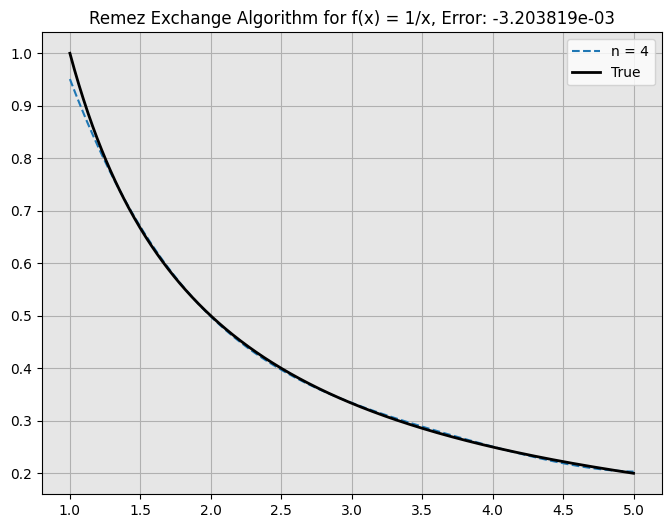

In [6]:
x_vals = np.linspace(lb, ub, 500)
x_ticks = np.round(np.linspace(lb + (ub - lb)/5, ub - (ub - lb)/5, 5), 2)
f_true = f(x_vals)
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
        
poly_approx = np.polyval(ys[::-1][1:], x_vals)

axs.plot(x_vals, poly_approx, '--', label=f"n = {n}" , zorder = 1)  

axs.plot(x_vals, f_true, label=r"True", color='k', zorder = 2, linewidth = 2)
axs.legend()
axs.grid(True)
axs.set_axisbelow(True)
plt.gca().set_facecolor((0.9, 0.9, 0.9)) 
axs.set_title(f"Remez Exchange Algorithm for f(x) = 1/x, Error: {ys[-1]:e}")
plt.show()

In [7]:
# Degree first, then down 
x_vals = np.linspace(1, 5, 1000)
poly_approx = np.polyval(ys[::-1][1:], x_vals)

In [55]:
# Exercise 20, part 2
# Getting random symmetric matrix
size = 1000
Q = ortho_group.rvs(size)
Evals = np.random.uniform(1, 5, size)
R = np.diag(Evals)
Mat = Q @ R @ Q.T
b = np.random.uniform(0, 1, size)
Actual_sol = sp.linalg.solve(Mat,b, assume_a='pos')

In [56]:
# Estimating the Soln of the system with my poly_approx
# Backward
Backward_error = np.linalg.norm(poly_approx - Actual_sol, ord = 2)/ np.linalg.norm(Actual_sol, ord=2)
Forward_error =  np.linalg.norm(Mat @ poly_approx - b, ord=2) / np.linalg.norm(b, ord = 2)

In [57]:
print("Backward_error: ", Backward_error )
print("Forward_error: ", Forward_error)

Backward_error:  1.3212700182316743
Forward_error:  1.9238766581643707


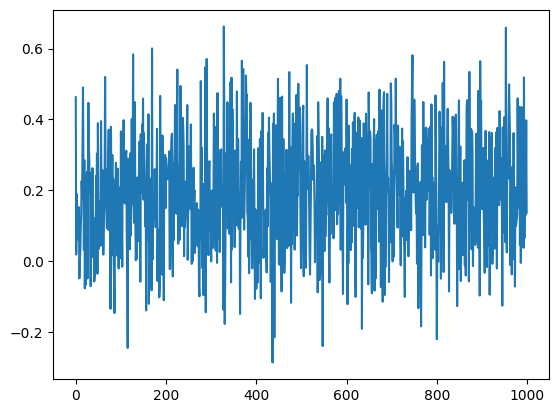

In [58]:
plt.plot(Actual_sol)

In [ ]:
x_line = np.linspace(1, 5, 1000)


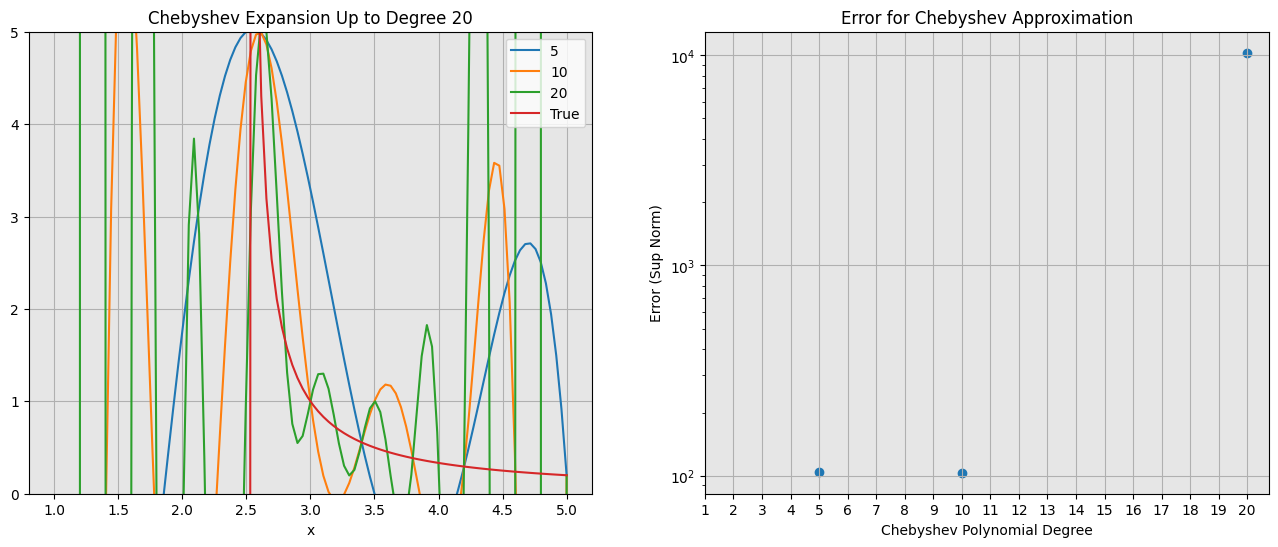

In [59]:
def mapping(x):
    #[1,5] -> [-1, 1]
    return 0.5 * x - 3/2
def unmapping(x):
    #[-1, 1] -> [1, 5]
    return 2*x+3

C:\Users\Caleb\AppData\Local\Temp\ipykernel_22420\4161058432.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(sm.lambdify(x, inte, modules = ['numpy']), -1, 1)[0]


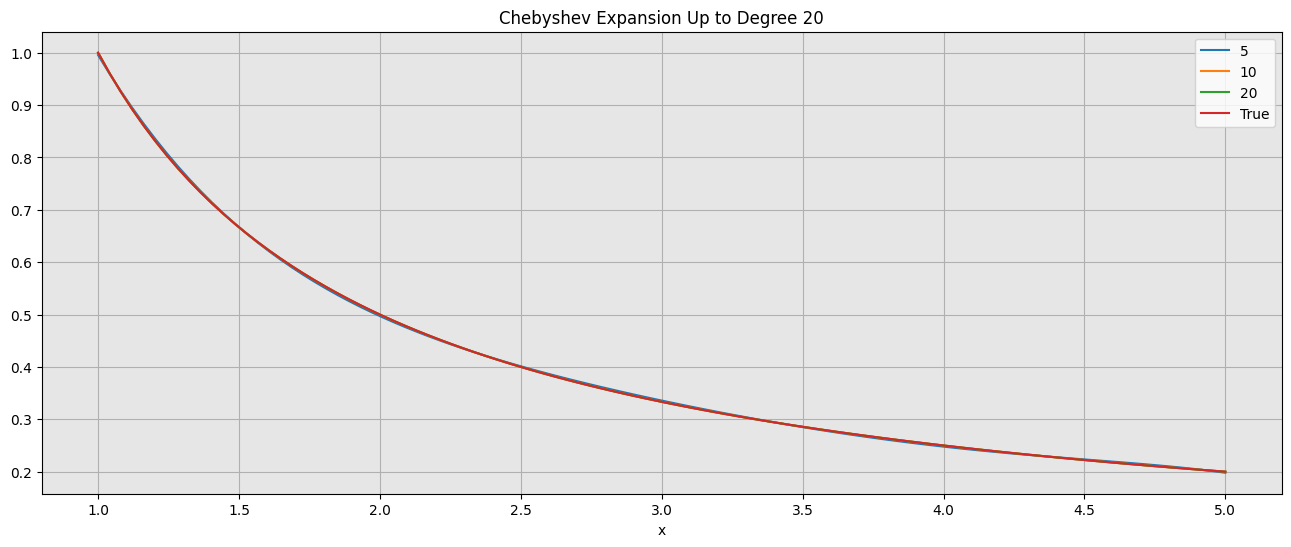

In [60]:
def coeff_eval(x: sm.core.symbol.Symbol, f : sm.Function, Cheby_poly : sm.Function, k: int):
    """
    Calcuates the Coefficients to the
    Chebyshev expansion. 
    """
    inte = 0
    if k == 0:
        inte = (1./sm.pi) * f / (sm.sqrt(1 - x**2))
    else :
        inte = (2. / sm.pi) * f * Cheby_poly / (sm.sqrt(1 - x**2))
    
    return integrate.quad(sm.lambdify(x, inte, modules = ['numpy']), -1, 1)[0]
   
    
def Cheb (x : sm.core.symbol.Symbol, n_eval: int):
    """
    Returns the n-th Chebyshev polynomial.
    """
    j = sm.symbols('j', integer = True)
    n = sm.Symbol('n', integer = True)
    series = sm.Sum(sm.binomial(n, 2*j)* (x**2 - 1)**j * x**(n - 2*j), (j, 0, sm.floor(n/2)))
    return series.subs({n: n_eval}).doit()

def Cheb_expansion(f : sm.Function, k : int, cheb_dict: dict):
    x = sm.Symbol('x')    
    cheb_coeff = np.zeros(k+1)
    cheb_funcs = []
    for i in range(k+1):
        cheb = Cheb(x, i)
        if i not in cheb_dict.keys():
            cheb_coeff[i] = coeff_eval(x, f, cheb, i)    
            cheb_dict[i] = cheb_coeff[i]
        else :
            cheb_coeff[i] = cheb_dict[i]
            
        cheb_funcs.append(cheb) 

    return cheb_coeff, cheb_funcs

def sup_norm(f_true : np.ndarray, f_approx : np.ndarray):
    f_diff = np.abs(f_true - f_approx)
    return np.max(f_diff)



### COMPUTING THE COEFFICIENTS
cheb_dict = {}

xs = np.linspace(1, 5, 100)
x = sm.Symbol('x')
f_map = 1/(2*x+3)

ks = range(1, 21, 1)
approxs = np.zeros((len(ks), 100))

lam_x = sm.lambdify(x, 1/x, modules=['numpy'])

for i, k in enumerate(ks):
    cheb_coeff, cheb_func = Cheb_expansion(f_map, k, cheb_dict)
    sum = 0
    lam_approx = 0
    for j in range(len(cheb_coeff)):
        sum += cheb_coeff[j] * cheb_func[j]
    lam_approx = sm.lambdify(x, sum, modules=['numpy'])
    approxs[i, :] = lam_approx(mapping(xs))


fig, axs = plt.subplots(1, 1, figsize = (16, 6))

for i in range(len(approxs)+1):
    if i in [5, 10, 20]:
        axs.plot(xs, approxs[i-1, :], label = f'{ks[i-1]}')

axs.plot(xs, lam_x(xs), label = "True")

# Plotting Aesthetics
axs.set_title(f'Chebyshev Expansion Up to Degree {ks[-1]}')
axs.legend()
axs.grid(True)
axs.set_facecolor((0.9, 0.9, 0.9)) 
axs.set_xlabel("x")

plt.show()

In [61]:
cheb_dict

{0: 0.4472135955001181,
 1: -0.34164078650041596,
 2: 0.13049516849971537,
 3: -0.049844718999268754,
 4: 0.019038988497201665,
 5: -0.0072722464943210914,
 6: 0.0027777509857126854,
 7: -0.0010610064640856462,
 8: 0.0004052684065454605,
 9: -0.00015479875670084352,
 10: 5.912786553281969e-05,
 11: -2.258483567550649e-05,
 12: 8.62664127682767e-06,
 13: -3.295084466359229e-06,
 14: 1.2586120592473202e-06,
 15: -4.807296146222339e-07,
 16: 1.836185556099068e-07,
 17: -7.01356324169096e-08,
 18: 2.6785472939749653e-08,
 19: -1.0229983838348928e-08,
 20: 3.904074036865044e-09}

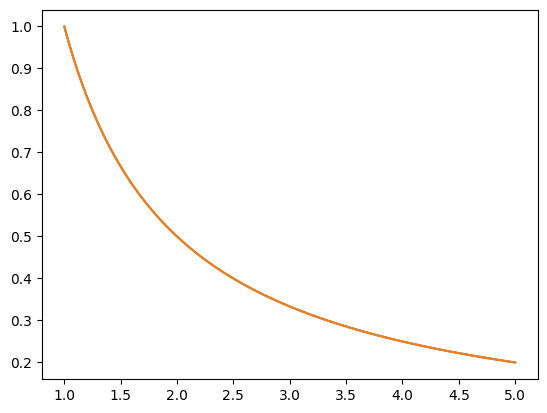

In [161]:
xs = np.linspace(-1, 1, 200)
f_approx = np.zeros_like(xs)
sum = 0
for i in range(len(cheb_dict.keys())):
    sum += cheb_dict[i] * Cheb(x, i)
lam_sum = sm.lambdify(x, sum, modules=['numpy'])
f_approx = lam_sum(xs)
plt.plot(unmapping(xs), f_approx)
plt.plot(unmapping(xs), 1/unmapping(xs))

In [159]:
f_approx

array([1.        , 0.98029557, 0.96135266, 0.94312796, 0.92558139,
       0.9086758 , 0.89237668, 0.87665198, 0.86147186, 0.84680851,
       0.83263599, 0.81893004, 0.80566802, 0.79282868, 0.78039216,
       0.76833977, 0.75665399, 0.74531835, 0.73431734, 0.72363636,
       0.71326165, 0.70318021, 0.69337979, 0.6838488 , 0.67457627,
       0.66555184, 0.65676568, 0.64820847, 0.63987138, 0.63174603,
       0.62382445, 0.61609907, 0.60856269, 0.60120846, 0.59402985,
       0.58702065, 0.58017493, 0.57348703, 0.56695157, 0.56056338,
       0.55431755, 0.54820937, 0.54223433, 0.53638814, 0.53066667,
       0.52506596, 0.51958225, 0.51421189, 0.50895141, 0.50379747,
       0.49874687, 0.49379653, 0.48894349, 0.48418492, 0.47951807,
       0.47494033, 0.47044917, 0.46604215, 0.46171694, 0.45747126,
       0.45330296, 0.44920993, 0.44519015, 0.44124168, 0.43736264,
       0.4335512 , 0.42980561, 0.4261242 , 0.42250531, 0.41894737,
       0.41544885, 0.41200828, 0.40862423, 0.40529532, 0.40202